<a href="https://colab.research.google.com/github/rahiakela/genai-research-and-practice/blob/main/rag-system-notebooks/05_semi_structured_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

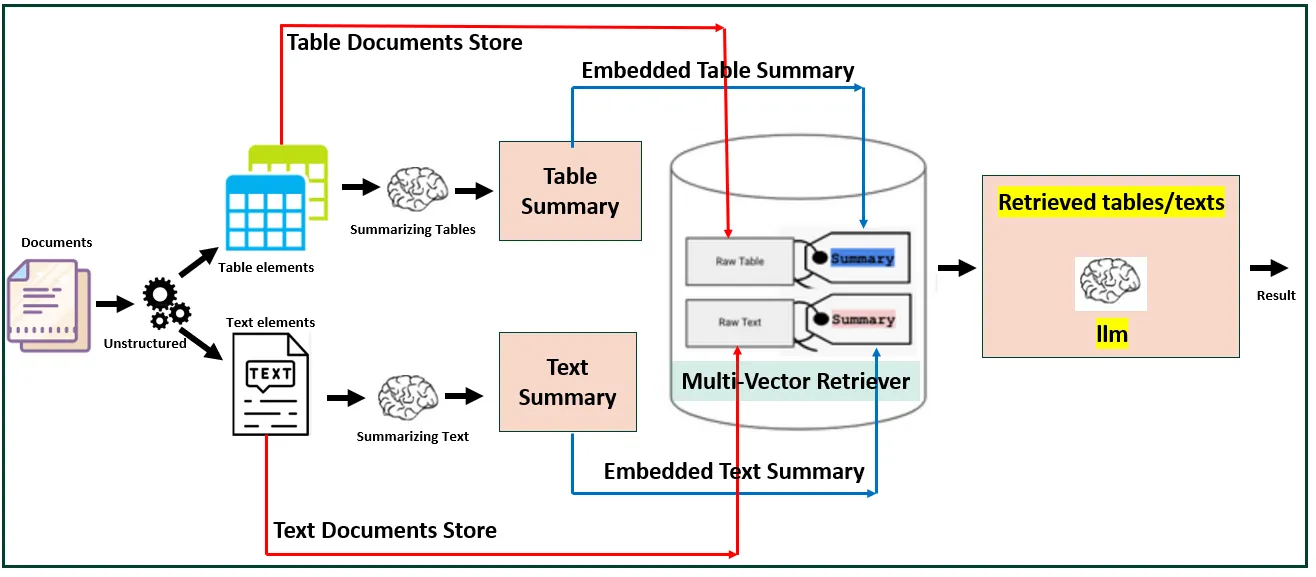

##Setup

**Refernce**:

https://medium.com/thedeephub/semi-structure-data-and-rag-pipeline-d0fc83c7cc37

In [ ]:
!pip install langchain langchain_openai chromadb unstructured[all-docs] pydantic lxml langchainhub

In [ ]:
!apt-get install tesseract-ocr
!apt-get install libpoppler-cpp-dev
!apt-get install poppler-utils

In [ ]:
from typing import Any

from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf

from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import AzureChatOpenAI, AzureOpenAIEmbeddings

import uuid
from google.colab import userdata

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

In [ ]:
from chromadb.utils import embedding_functions

embeddings = embedding_functions.DefaultEmbeddingFunction()

In [ ]:
"""
embeddings = AzureOpenAIEmbeddings(
    openai_api_key=userdata.get("AZURE_OPENAI_API_KEY"),
    openai_api_version="2024-02-01",
    azure_endpoint=userdata.get("AZURE_OPENAI_ENDPOINT")
)
"""

llm = AzureChatOpenAI(
    openai_api_key=userdata.get("AZURE_OPENAI_API_KEY"),
    openai_api_version="2024-02-01",
    azure_endpoint=userdata.get("AZURE_OPENAI_ENDPOINT"),
    deployment_name=userdata.get("DEPLOYMENT_NAME"),
)

## Data Loading

In [ ]:
!mkdir output

# Get elements
raw_pdf_elements = partition_pdf(
    filename="llama2.pdf",
    extract_images_in_pdf=False, # Unstructured first finds embedded image blocks
    infer_table_structure=True,  # Use layout model (YOLOX) to get bounding boxes (for tables)
    chunking_strategy="by_title",# Post processing to aggregate text once we have the title
    max_characters=4000,         # Chunking params to aggregate text blocks
    new_after_n_chars=3800,      # Attempt to create a new chunk 3800 chars
    combine_text_under_n_chars=2000, # Attempt to keep chunks > 2000 chars
    image_output_dir_path="output"
)

In [ ]:
set([str(type(x)) for x in raw_pdf_elements])

{"<class 'unstructured.documents.elements.CompositeElement'>",
 "<class 'unstructured.documents.elements.Table'>",
 "<class 'unstructured.documents.elements.TableChunk'>"}

In [ ]:
# Create a dictionary to store counts of each type
category_counts = {}

for element in raw_pdf_elements:
    category = str(type(element))
    if category in category_counts:
        category_counts[category] += 1
    else:
        category_counts[category] = 1

# Unique_categories will have unique elements
unique_categories = set(category_counts.keys())
category_counts

{"<class 'unstructured.documents.elements.CompositeElement'>": 114,
 "<class 'unstructured.documents.elements.Table'>": 44,
 "<class 'unstructured.documents.elements.TableChunk'>": 6}

In [ ]:
class Element(BaseModel):
  type: str
  text: Any

In [ ]:
# Categorize by type
categorized_elements = []
for element in raw_pdf_elements:
  if "unstructured.documents.elements.Table" in str(type(element)):
    categorized_elements.append(Element(type="table", text=str(element)))
  elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
    categorized_elements.append(Element(type="text", text=str(element)))

# tables
table_elements = [e for e in categorized_elements if e.type == "table"]
print(len(table_elements))

# text
text_elements = [e for e in categorized_elements if e.type == "text"]
print(len(text_elements))

50
114


In [ ]:
table_elements[1]

Element(type='table', text='Llama 1 Llama 2 Training Data See Touvron et al. (2023) A new mix of publicly available online data Params 7B 13B 33B 65B 7B 13B 34B 70B Context Length 2k 2k 2k 2k 4k 4k 4k 4k GQA ✗ ✗ ✗ ✗ ✗ ✗ ✓ ✓ Tokens 1.0T 1.0T 1.4T 1.4T 2.0T 2.0T 2.0T 2.0T LR 3.0 × 10−4 3.0 × 10−4 1.5 × 10−4 1.5 × 10−4 3.0 × 10−4 3.0 × 10−4 1.5 × 10−4 1.5 × 10−4')

In [ ]:
text_elements[2]

Element(type='text', text='1 Introduction\n\nLarge Language Models (LLMs) have shown great promise as highly capable AI assistants that excel in complex reasoning tasks requiring expert knowledge across a wide range of fields, including in specialized domains such as programming and creative writing. They enable interaction with humans through intuitive chat interfaces, which has led to rapid and widespread adoption among the general public.\n\nThe capabilities of LLMs are remarkable considering the seemingly straightforward nature of the training methodology. Auto-regressive transformers are pretrained on an extensive corpus of self-supervised data, followed by alignment with human preferences via techniques such as Reinforcement Learning with Human Feedback (RLHF). Although the training methodology is simple, high computational requirements have limited the development of LLMs to a few players. There have been public releases of pretrained LLMs (such as BLOOM (Scao et al., 2022), LLa

## Summaries

In [ ]:
# let's create a simple summarize chain for each element

# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text. \
Give a concise summary of the table or text. Table or text chunk: {element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
summarize_chain = { "element": lambda x: x} | prompt | llm | StrOutputParser()

In [ ]:
# Apply to tables
tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

In [ ]:
# Apply to texts
texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

RateLimitError: Error code: 429 - {'error': {'code': '429', 'message': 'Requests to the ChatCompletions_Create Operation under Azure OpenAI API version 2024-02-01 have exceeded call rate limit of your current OpenAI S0 pricing tier. Please retry after 1 second. Please go here: https://aka.ms/oai/quotaincrease if you would like to further increase the default rate limit.'}}

In [ ]:
table_summaries[1]

"The table shows the parameters, context length, GQA, tokens, and LR for Llama 1 and Llama 2 training data, which can be found in Touvron et al.'s research. Llama 2 has a longer context length and includes GQA, while both Llama 1 and Llama 2 have increasing parameters and tokens as the model size increases. The LR decreases as the model size increases."

In [ ]:
text_summaries[2]

'The article discusses the development and release of Llama 2, a family of highly capable Large Language Models (LLMs) that excel in complex reasoning tasks requiring expert knowledge across a wide range of fields. Llama 2 models are pretrained and fine-tuned at scales up to 70B parameters, and are generally found to perform better than existing open-source models on helpfulness and safety benchmarks. The paper also contributes a thorough description of the fine-tuning methodology and approach to improving LLM safety, which the authors hope will enable the community to reproduce fine-tuned LLMs and continue to improve their safety. The article concludes by sharing safety human evaluation results for Llama 2-Chat compared to other open-source and closed-source models.'

## Multi-vector retriever

In [ ]:
# let's include metadata to summary table and summary text list

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="summaries", embedding_function=embeddings)

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key
)

In [ ]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

NotFoundError: Error code: 404 - {'error': {'code': 'DeploymentNotFound', 'message': 'The API deployment for this resource does not exist. If you created the deployment within the last 5 minutes, please wait a moment and try again.'}}

In [ ]:
# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

## Multi-vector retriever